# Setup

In [114]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [115]:
from sparse_field_lib import load_data

In [116]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [117]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [118]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [119]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


## Utility Functions

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Load data

In [121]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [122]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [151]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)
is_star = fits_file['probpsf'][:].astype(bool)

# remove all locations that are not inside the image. 
keep = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1)
pt = pt[keep]
pr = pr[keep]
is_star = is_star[keep]

keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]

# Prepare model

In [124]:
# prepare BLISS model 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
sleep_net.galaxy_encoder.eval()
image_encoder = image_encoder.eval()

# Loop over chunks

In [150]:
bpad = image_encoder.border_padding
slen = 300  
plen = slen + bpad*2
h,w = frame.shape

locs = torch.tensor([])
galaxy_bool = torch.tensor([])


with torch.no_grad():
    for i in range(h//slen):
        for j in range(w//slen):
            print(i,j)
            y1, y2 = i*slen, (i+1)*slen
            x1, x2 = j*slen, (j+1)*slen
            chunk = frame[y1:y2, x1:x2]
            pchunk = np.zeros((plen, plen), dtype=np.float32) + np.mean(frame[frame < 900])
            pchunk = pchunk + np.sqrt(pchunk) * np.random.randn(plen, plen)
            pchunk[bpad:plen-bpad, bpad:plen-bpad] = chunk
            pchunk = pchunk.astype(np.float32)
            pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, plen, plen)
            
            # get estimates with BLISS trained model. 
            tile_est = sleep_net.tile_images_map_estimate(pchunk)
            est_params = encoder.get_full_params(tile_est, slen)
            
            _locs = est_params['locs'].cpu()
            _galaxy_bool = est_params['galaxy_bool'].cpu().reshape(-1, 1)
            
            _locs = _locs.reshape(-1, 2)
            x, y = _locs[:, 1].reshape(-1, 1), _locs[:, 0].reshape(-1, 1)
            x = x*slen + x1 - 0.5 
            y = y*slen + y1 - 0.5 # pixels, same format as pt,pr
            locs1 = torch.hstack((x,y)).reshape(-1, 2).cpu()
            locs  = torch.cat((locs, locs1))
            
            _galaxy_bool = _galaxy_bool.reshape(-1, 1)
            galaxy_bool = torch.cat((galaxy_bool, _galaxy_bool))
            

            # delete extra stuff in GPU and clear cache for next iteration.
            del pchunk
            del tile_est
            del est_params
            torch.cuda.empty_cache()
            
#             #look reasonable
#             plt.figure()
#             plt.imshow(chunk, vmin=800, vmax=1000)
#             plt.scatter(_locs[:,1]*slen-0.5, _locs[:,0]*slen-0.5, marker='x', s=10, color='r')
            
            
locs = locs.numpy()
galaxy_bool = galaxy_bool.numpy()

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5


# Visualize Frame

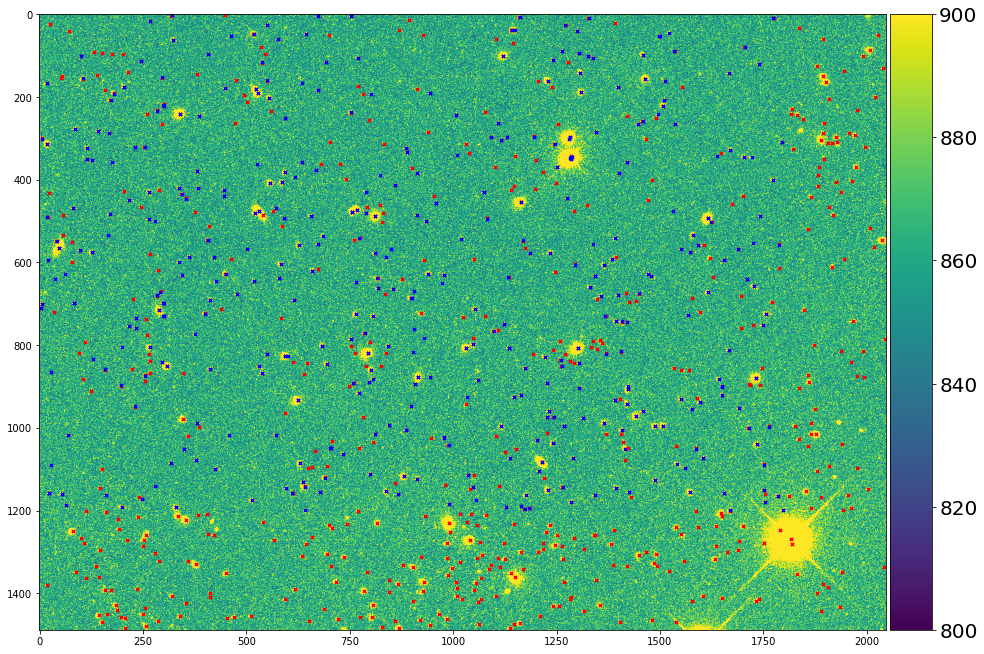

In [126]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
imshow_cbar(fig, ax, frame, vmin=800, vmax=900)
ax.scatter(x=pt, y=pr, c='r', marker='x', s=10)
ax.scatter(x=locs[:,0], y=locs[:, 1], c='b', marker='x', s=10)

# Match objects

In [174]:
from bliss.metrics import inner_join_locs
_plocs = torch.from_numpy(np.hstack((pt.reshape(-1, 1), pr.reshape(-1, 1))))
_locs = torch.from_numpy(locs)
_galaxy_bool = torch.from_numpy(galaxy_bool)

# do matching
_plocs, _locs, row_indx, col_indx = inner_join_locs(_plocs, _locs)

# need to apply it to galaxy bool as well.
_galaxy_bool = _galaxy_bool[col_indx].reshape(-1).numpy()
_is_star = is_star[row_indx].reshape(-1).astype(np.float32)

In [185]:
_galaxy_bool.shape

(443,)

# Results

In [181]:
print('# of objects found: ', len(_locs) / len(pt))

# of objects found:  0.5462392108508015


(array([21., 59., 73., 40., 36., 22., 17., 17.,  7.,  5.,  7.,  4.,  4.,
         3.,  3.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 [<matplotlib.patches.Polygon at 0x7f6f419c6d30>])

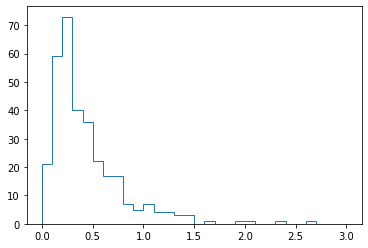

In [182]:
# histogram of mse between matching locations 
mse = (_plocs - _locs).pow(2).sum(1).pow(0.5).numpy()
plt.hist(mse, bins=30, range=(0, 3), histtype='step')

In [183]:
print('# misclassifications:', np.sum(_is_star != _galaxy_bool) / len(_galaxy_bool))

# misclassifications: 0.5553047404063205


In [184]:
_is_star

array([1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0.